# Predict corona cases

In [2]:
#!pip install convoys
import convoys
import pandas as pd
import requests
import io
import cloudpickle as cp
from fbprophet import Prophet
import numpy as np


Importing plotly failed. Interactive plots will not work.


In [4]:
df = pd.read_csv(io.StringIO(requests.get("https://github.com/openZH/covid_19/raw/master/fallzahlen_kanton_total_csv/COVID19_Fallzahlen_Kanton_ZH_total.csv").content.decode('utf-8')))


ConnectionError: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /openZH/covid_19/raw/master/fallzahlen_kanton_total_csv/COVID19_Fallzahlen_Kanton_ZH_total.csv (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x11d993f10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [19]:
max_cases = 25000
periods = 20a

In [20]:
df = pd.read_csv(io.StringIO(requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv").content.decode('utf-8')))
df = df[df["Country/Region"] == "Switzerland"].T.iloc[4:].reset_index()
df.columns = ["ds", "y"]
df["ds"] = pd.to_datetime(df["ds"],infer_datetime_format=True).dt.date
df["cap"] = max_cases
df = df[df["y"]>0]
df.reset_index(drop=True)
df.head()

,ds,y,cap
34,2020-02-25,1,25000
35,2020-02-26,1,25000
36,2020-02-27,8,25000
37,2020-02-28,8,25000
38,2020-02-29,18,25000


In [76]:
m = Prophet(mcmc_samples=50,growth='logistic').fit(df);
future = m.make_future_dataframe(periods=periods,freq='d')
future["cap"] = max_cases #whats the max RW we can reach
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper',"cap"]]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


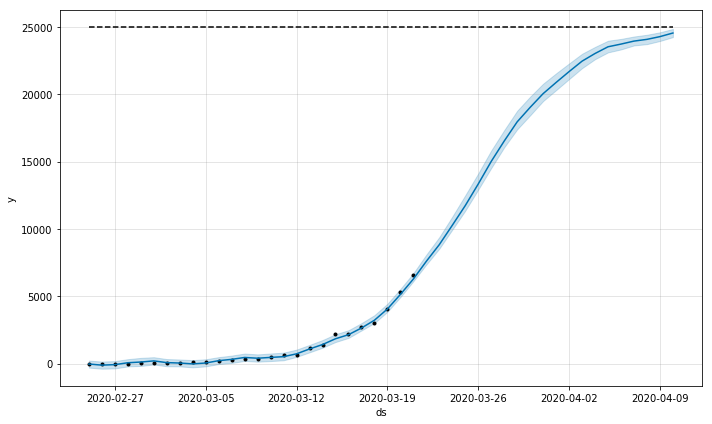

In [77]:
fig1 = m.plot(forecast)

In [78]:
df['ds'] = df['ds'].astype('datetime64[ns]')
result = pd.merge(df,forecast,on="ds",how="right")[["ds","y","yhat",'yhat_lower', 'yhat_upper',"cap_y"]]

In [98]:
for index,row in result.iterrows():
    if pd.isnull(row.y):
        result.loc[index,"y_merge"] = row.yhat
    else:
        result.loc[index,"y_merge"] = row.y

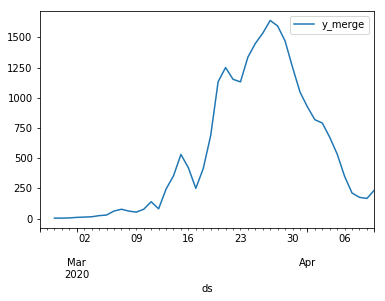

In [103]:
#pd.DataFrame([forecast["ds"],forecast["yhat"].diff()])#.plot()
tmp = result["ds"].to_frame().join(result["y_merge"].diff().rolling(2).mean())#.plot()
tmp.index = tmp["ds"]
tmp[["y_merge"]].plot()
#tmp.plot()

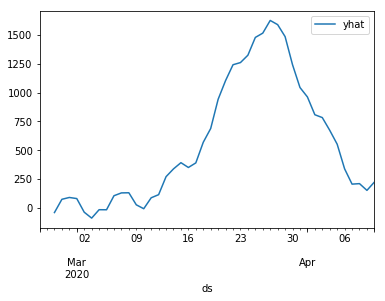

In [44]:
#pd.DataFrame([forecast["ds"],forecast["yhat"].diff()])#.plot()
tmp = forecast["ds"].to_frame().join(forecast["yhat"].diff().rolling(2).mean())#.plot()
tmp.index = tmp["ds"]
tmp[["yhat"]].plot()
#tmp.plot()

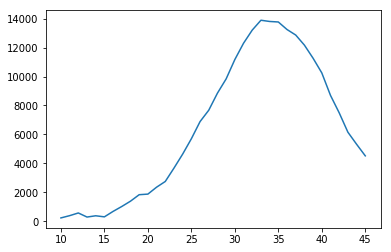

In [31]:
forecast["yhat"].diff().rolling(10).sum().plot()